# Unleash the Ray - Grid Search

Let's revisit our grid search example but now with Ray

A lot of this code is going to be familiar as we already had our pipeline wraped in a function

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("bright", 8))

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_f1_score, f1_score

In [ ]:
import ray
from ray import tune

### Let's start Ray

In [ ]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=0, include_dashboard=True)

After initialisation the [Ray Dashboard](https://docs.ray.io/en/master/ray-dashboard.html) is available on the **webui_url** port

## Setup some raytune compatible training code

Very similar to before except now we have an end-to-end function

In [ ]:

# differences from what we've seen before, this is an end to end training function
# where we are loading the dataset running our complete train and test loop whilst
# 
def e2e_simple_training(config):
    
    #threadsafe
    X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
    
    # chose your CV strategy
    splitter = StratifiedKFold(n_splits=5)
    
    # run k fold training and testing
    f1_scores = [] # keep hold of all individual scores
    for train_ind, test_ind in splitter.split(X, y):
        pipeline = make_pipeline(RobustScaler(),
                                  RandomForestClassifier(random_state=42))

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[test_ind])

        f1_scores.append(f1_score(y_pred, y[test_ind]))

    # use tunes reporter to send metric to tune.run()
    tune.report(mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std())


                # and we can actually add any metrics we like)

Previously we had a param grid like this

```
param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__bootstrap': [True, False]
}
```

### TODO convert this to a set of ray search spaces

The Ray config object is freeform, we imprint our own structure.

However, tunable parameters need to be represented by tune distribution object >> [read the docs](https://docs.ray.io/en/latest/tune/api_docs/grid_random.html?highlight=tune.grid#random-distributions-api)

In [ ]:
ray_tuning_config = {
    'randomforestclassifier__n_estimators': tune.grid_search([1,5,15])
}

In [ ]:
analysis = tune.run(
                e2e_simple_training,
                metric='mean_f1_score',
                mode='max',
                config=ray_tuning_config,
                resources_per_trial=dict(cpu=1, gpu=0),
                local_dir="~/ray_results/grid_search")

In [ ]:
df = analysis.dataframe()
print(df.columns)
df.head()

In [ ]:
print("Best config: ", analysis.get_best_config(metric="mean_f1_score"))

In [ ]:
from scipy.stats import norm

def plot_some_tune_results(df):
    fig, ax = plt.subplots(1, 1, figsize=(16,6))
    x = np.linspace(0.85, 1.0, 100)

    n_estimators = df['config/randomforestclassifier__n_estimators'].values.tolist()

    lines = []
    for mu, sigma in zip(df['mean_f1_score'], df['std_f1_score']):
        pdf = norm.pdf(x, mu, sigma)
        line, = ax.plot(x, pdf, alpha=0.6)
        ax.axvline(mu, color=line.get_color())
        ax.text(mu, pdf.max(), f"{mu:.3f}", color=line.get_color(), fontsize=14)
        lines.append(line)

    plt.legend(handles=lines, labels=n_estimators, title="n estimators")
    ax.set_title(f"Average F1 Scores")
    
plot_some_tune_results(df)

## Really increase the size of the search space

In [ ]:
#
# 6D search space - 960 combinations - 4800 calls to fit
#

ray_tuning_config = {
    'randomforestclassifier__n_estimators': tune.grid_search([1,5,15,50,100]),
    'randomforestclassifier__criterion': tune.grid_search(['gini', 'entropy']),
    'randomforestclassifier__max_features': tune.grid_search(['auto', 'sqrt', 'log2']),
#     'randomforestclassifier__bootstrap': tune.grid_search([True, False]),
#     'randomforestclassifier__min_samples_leaf': tune.grid_search([1,2,3,4]),
 #   'randomforestclassifier__min_samples_split': tune.grid_search([3,4,5,6])
}

In [119]:
analysis = tune.run(
                e2e_simple_training,
                metric='mean_f1_score',
                mode='max',
                config=ray_tuning_config,
                resources_per_trial=dict(cpu=1, gpu=0)
                )

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__n_estimators
e2e_simple_training_23cc1_00001,PENDING,,entropy,auto,1
e2e_simple_training_23cc1_00002,PENDING,,gini,sqrt,1
e2e_simple_training_23cc1_00003,PENDING,,entropy,sqrt,1
e2e_simple_training_23cc1_00004,PENDING,,gini,log2,1
e2e_simple_training_23cc1_00005,PENDING,,entropy,log2,1
e2e_simple_training_23cc1_00006,PENDING,,gini,auto,5
e2e_simple_training_23cc1_00007,PENDING,,entropy,auto,5
e2e_simple_training_23cc1_00008,PENDING,,gini,sqrt,5
e2e_simple_training_23cc1_00009,PENDING,,entropy,sqrt,5
e2e_simple_training_23cc1_00010,PENDING,,gini,log2,5


Result for e2e_simple_training_23cc1_00000:
  date: 2020-11-09_12-53-12
  done: false
  experiment_id: b0a34c4a52264196a97a1acf41d3b33f
  experiment_tag: 0_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=auto,randomforestclassifier__n_estimators=1
  hostname: Schlepptop
  iterations_since_restore: 1
  mean_f1_score: 0.9267873910127431
  node_ip: 192.168.123.68
  pid: 21788
  std_f1_score: 0.022471880003588674
  time_since_restore: 0.22307682037353516
  time_this_iter_s: 0.22307682037353516
  time_total_s: 0.22307682037353516
  timestamp: 1604922792
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 23cc1_00000
  
Result for e2e_simple_training_23cc1_00001:
  date: 2020-11-09_12-53-12
  done: false
  experiment_id: 5d225b3e33424901802e9f91902d4c08
  experiment_tag: 1_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=auto,randomforestclassifier__n_estimators=1
  hostname: Schlepptop
  iterations_since_restore: 1
  mea

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__n_estimators,iter,total time (s),mean_f1_score,std_f1_score
e2e_simple_training_23cc1_00020,PENDING,,gini,sqrt,50,,,,
e2e_simple_training_23cc1_00021,PENDING,,entropy,sqrt,50,,,,
e2e_simple_training_23cc1_00022,PENDING,,gini,log2,50,,,,
e2e_simple_training_23cc1_00023,PENDING,,entropy,log2,50,,,,
e2e_simple_training_23cc1_00024,PENDING,,gini,auto,100,,,,
e2e_simple_training_23cc1_00025,PENDING,,entropy,auto,100,,,,
e2e_simple_training_23cc1_00026,PENDING,,gini,sqrt,100,,,,
e2e_simple_training_23cc1_00010,RUNNING,,gini,log2,5,,,,
e2e_simple_training_23cc1_00011,RUNNING,192.168.123.68:22063,entropy,log2,5,1,0.279562,0.957007,0.01904
e2e_simple_training_23cc1_00012,RUNNING,,gini,auto,15,,,,


Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__n_estimators,iter,total time (s),mean_f1_score,std_f1_score
e2e_simple_training_23cc1_00024,RUNNING,192.168.123.68:22408,gini,auto,100,1,2.08506,0.965198,0.0183413
e2e_simple_training_23cc1_00025,RUNNING,,entropy,auto,100,,,,
e2e_simple_training_23cc1_00026,RUNNING,,gini,sqrt,100,,,,
e2e_simple_training_23cc1_00027,RUNNING,,entropy,sqrt,100,,,,
e2e_simple_training_23cc1_00028,RUNNING,,gini,log2,100,,,,
e2e_simple_training_23cc1_00029,RUNNING,,entropy,log2,100,,,,
e2e_simple_training_23cc1_00000,TERMINATED,,gini,auto,1,1,0.223077,0.926787,0.0224719
e2e_simple_training_23cc1_00001,TERMINATED,,entropy,auto,1,1,0.259257,0.938303,0.018497
e2e_simple_training_23cc1_00002,TERMINATED,,gini,sqrt,1,1,0.328111,0.926787,0.0224719
e2e_simple_training_23cc1_00003,TERMINATED,,entropy,sqrt,1,1,0.19537,0.938303,0.018497


Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__n_estimators,iter,total time (s),mean_f1_score,std_f1_score
e2e_simple_training_23cc1_00000,TERMINATED,,gini,auto,1,1,0.223077,0.926787,0.0224719
e2e_simple_training_23cc1_00001,TERMINATED,,entropy,auto,1,1,0.259257,0.938303,0.018497
e2e_simple_training_23cc1_00002,TERMINATED,,gini,sqrt,1,1,0.328111,0.926787,0.0224719
e2e_simple_training_23cc1_00003,TERMINATED,,entropy,sqrt,1,1,0.19537,0.938303,0.018497
e2e_simple_training_23cc1_00004,TERMINATED,,gini,log2,1,1,0.343216,0.929829,0.0161172
e2e_simple_training_23cc1_00005,TERMINATED,,entropy,log2,1,1,0.23641,0.939078,0.0171929
e2e_simple_training_23cc1_00006,TERMINATED,,gini,auto,5,1,0.456873,0.960576,0.028015
e2e_simple_training_23cc1_00007,TERMINATED,,entropy,auto,5,1,0.43366,0.953901,0.0195245
e2e_simple_training_23cc1_00008,TERMINATED,,gini,sqrt,5,1,0.350153,0.960576,0.028015
e2e_simple_training_23cc1_00009,TERMINATED,,entropy,sqrt,5,1,0.215526,0.953901,0.0195245


In [120]:
from pprint import pprint
print("Best config: ")
pprint(analysis.get_best_config(metric="mean_f1_score"))

Best config: 
{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__n_estimators': 50}


In [123]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")
df.head(10)

,mean_f1_score,std_f1_score,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,...,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,trial_id,experiment_tag,config/randomforestclassifier__criterion,config/randomforestclassifier__max_features,config/randomforestclassifier__n_estimators,logdir
0,0.926787,0.022472,0.223077,False,NaN,NaN,1,b0a34c4a52264196a97a1acf41d3b33f,2020-11-09_12-53-12,1604922792,...,192.168.123.68,0.223077,0,1,23cc1_00000,"0_randomforestclassifier__criterion=gini,rando...",gini,auto,1,/home/lena/ray_results/e2e_simple_training/e2e...
1,0.938303,0.018497,0.259257,False,NaN,NaN,1,5d225b3e33424901802e9f91902d4c08,2020-11-09_12-53-12,1604922792,...,192.168.123.68,0.259257,0,1,23cc1_00001,"1_randomforestclassifier__criterion=entropy,ra...",entropy,auto,1,/home/lena/ray_results/e2e_simple_training/e2e...
2,0.926787,0.022472,0.328111,False,NaN,NaN,1,1cdf3d2db318476a8d9c09482a4b9ed5,2020-11-09_12-53-12,1604922792,...,192.168.123.68,0.328111,0,1,23cc1_00002,"2_randomforestclassifier__criterion=gini,rando...",gini,sqrt,1,/home/lena/ray_results/e2e_simple_training/e2e...
3,0.938303,0.018497,0.195370,False,NaN,NaN,1,522f420c59af494e9c055ec0285f91a2,2020-11-09_12-53-13,1604922793,...,192.168.123.68,0.195370,0,1,23cc1_00003,"3_randomforestclassifier__criterion=entropy,ra...",entropy,sqrt,1,/home/lena/ray_results/e2e_simple_training/e2e...
4,0.929829,0.016117,0.343216,False,NaN,NaN,1,8c6724531dfa4753a38ed53b20ef8b13,2020-11-09_12-53-13,1604922793,...,192.168.123.68,0.343216,0,1,23cc1_00004,"4_randomforestclassifier__criterion=gini,rando...",gini,log2,1,/home/lena/ray_results/e2e_simple_training/e2e...
5,0.939078,0.017193,0.236410,False,NaN,NaN,1,36db840651634df58482211294ee6615,2020-11-09_12-53-13,1604922793,...,192.168.123.68,0.236410,0,1,23cc1_00005,"5_randomforestclassifier__criterion=entropy,ra...",entropy,log2,1,/home/lena/ray_results/e2e_simple_training/e2e...
6,0.960576,0.028015,0.456873,False,NaN,NaN,1,f6490ae3caa94f8eb24f4feaef49fad8,2020-11-09_12-53-13,1604922793,...,192.168.123.68,0.456873,0,1,23cc1_00006,"6_randomforestclassifier__criterion=gini,rando...",gini,auto,5,/home/lena/ray_results/e2e_simple_training/e2e...
7,0.953901,0.019525,0.433660,False,NaN,NaN,1,a179d7d9531647ecb3e2b6a713871e1d,2020-11-09_12-53-15,1604922795,...,192.168.123.68,0.433660,0,1,23cc1_00007,"7_randomforestclassifier__criterion=entropy,ra...",entropy,auto,5,/home/lena/ray_results/e2e_simple_training/e2e...
8,0.960576,0.028015,0.350153,False,NaN,NaN,1,dd6f5f6ca1dd428e9cecffff85434107,2020-11-09_12-53-15,1604922795,...,192.168.123.68,0.350153,0,1,23cc1_00008,"8_randomforestclassifier__criterion=gini,rando...",gini,sqrt,5,/home/lena/ray_results/e2e_simple_training/e2e...
9,0.953901,0.019525,0.215526,False,NaN,NaN,1,e6ac23a20fa1433e960691455288c47a,2020-11-09_12-53-15,1604922795,...,192.168.123.68,0.215526,0,1,23cc1_00009,"9_randomforestclassifier__criterion=entropy,ra...",entropy,sqrt,5,/home/lena/ray_results/e2e_simple_training/e2e...


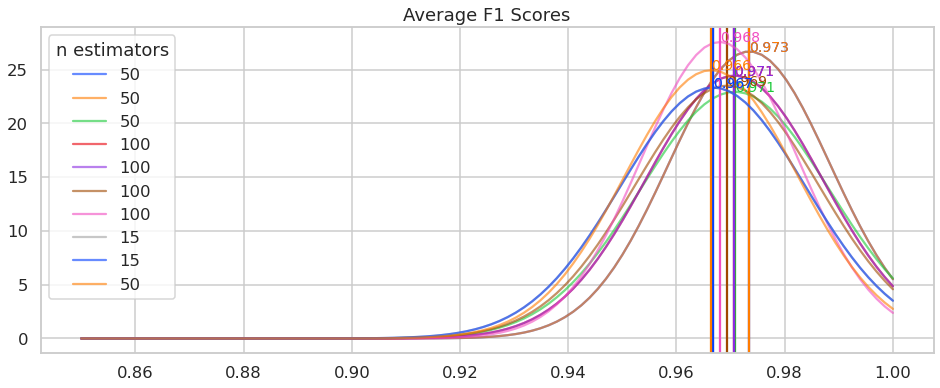

In [124]:
plot_some_tune_results(top_n_df)

In [125]:
%load_ext tensorboard

In [126]:
from tensorboard import notebook
%tensorboard --logdir "~/ray_results/grid_search"
notebook.display(height=1000) 

Launching TensorBoard...

Selecting TensorBoard with logdir ~/ray_results/grid_search (started 0:00:01 ago; port 6006, pid 22844).


### Once you are all done, shutdown Ray

In [127]:
ray.shutdown()